# Introduction

This is where my plans for the air quality index (AQI) prediction service are. With any coding project larger than a simple script, things can quickly get out of hand if careful planning isn't carried out before starting to code.

This project was born from an idea I found on [Twitter](https://datamachines.xyz/2022/11/22/build-a-prediction-service-with-machine-learning-step-by-step/) by Pau Labarta Bajo. At the link, he gives a short outline of the steps needed to complete the project. The steps are vague enough to warrant some serious learning by those who are not familiar with deploying machine learning models (me), but just detailed enough to know the rough path to take. This is a great departure from tutorials where you mindlessly watch someone code X project and then claim you've learned how to do X.

First, a quick outline of the project. The air quality index is a measure of the levels of specific pollutants in the air. Below is a table I copied from the Wikipedia page for [AQI](https://en.wikipedia.org/wiki/Air_quality_index#CAQI).

<tbody><tr>
<th>Qualitative name</th>
<th>Index or sub-index</th>
<th colspan="4">Pollutant (hourly) concentration
</th></tr>
<tr>
<th colspan="2"></th>
<th>NO<sub>2</sub> μg/m<sup>3</sup></th>
<th>PM<sub>10</sub> μg/m<sup>3</sup></th>
<th>O<sub>3</sub> μg/m<sup>3</sup></th>
<th>PM<sub>2.5</sub> (optional) μg/m<sup>3</sup>
</th></tr>
<tr>
<td>Very low</td>
<td style="background:#79bc6a;">0–25</td>
<td>0–50</td>
<td>0–25</td>
<td>0–60</td>
<td>0–15
</td></tr>
<tr>
<td>Low</td>
<td style="background:#bbcf4c;">25–50</td>
<td>50–100</td>
<td>25–50</td>
<td>60–120</td>
<td>15–30
</td></tr>
<tr>
<td>Medium</td>
<td style="background:#eec20b;">50–75</td>
<td>100–200</td>
<td>50–90</td>
<td>120–180</td>
<td>30–55
</td></tr>
<tr>
<td>High</td>
<td style="background:#f29305;">75–100</td>
<td>200–400</td>
<td>90–180</td>
<td>180–240</td>
<td>55–110
</td></tr>
<tr>
<td>Very high</td>
<td style="background:#e8416f;">&gt;100</td>
<td>&gt;400</td>
<td>&gt;180</td>
<td>&gt;240</td>
<td>&gt;110
</td></tr>
</tbody>

The objective is to train a machine learning model on historical time-series AQI data for a given city and then produce a 3-day hourly forecast of the AQI for the city. New data will be downloaded frequently and this data, along with the historical data and the forecast, will be presented in a plot in an online app. The model will be retrained once a week. I think I will use Meta's Prophet, which is a procedure for forecasting time-series data, because it is very good at forecasting on data that has strong seasonality, as we will see the AQI data has.

The AQI data from OpenWeather is categorized as 1-5, with 5 being the worst air quality, rather than the sub-index shown in the table above. Rather than turn this into a classification task, I think it will be better to have Prophet perform regression and then round the predictions to the closest integer, with an upper bound of 5.

## Technologies Used
---
1. Python
2. Meta Prophet
3. OpenWeatherAPI for air quality index data
4. Hopsworks as a feature storing service
5. Streamlit to build a simple data web app that shows the historical data and forecasted AQI, but might use Gradio and HuggingFace Spaces

## Step 1: Feature Generation

The first step is to write a script to generate the features and upload them to our feature store, Hopsworks. Our data source will be the OpenWeather API. OpenWeather has a backlog of AQI data starting from 2020 November 27. This data will be downloaded via GET request and processed by a Python script.

The script needs automatically decide whether to download all of the historical data for a given city or to only download a portion of data to augment what's already in the feature store. From there we'll do a little bit of processing and then send the data to Hopsworks.

In short, we need the following:
1. Have a function which determines the date range for which to download data
    * query Hopsworks for the feature group corresponding to a location's AQI data. If it doesn't exist, then we know we need to download all historical data and so the start date is 2020 November 27.
    * Input Parameters: FeatureStore object, feature group name
    * Output Parameters: tuple with a datetime object and corresponding ID number. the id number will help us write the data to a csv and allows us to have primary keys for each data point.
2. Have a function which submits a GET request for AQI data for a given time period and location.
   * Input Parameters: start_date, end_date, latitude, longitude, feature group name, id number to use to start index
   * Output: Pandas Dataframe of the AQI data
3. Store the features in Hopsworks.
    * We will have to query hopsworks every time we need to update the data stored in the cloud. That way we know the time period for which we need to download data. For example, the first time data is downloaded, we need to start at 27 November 2020 up until the current day. Afterward, we'll have to download new data starting at the newest data point that was last uploaded to Hopsworks.
    * Because of the need to query the data, we need to use online feature groups rather than offline ones. The difference is that online feature groups have less latency.

I'm working with time-series data here which is much different than simple tabular data about customers or flattened images. There are things such as seasonality that can be used to do feature engineering. For the sake of the project I'm not going to get too detailed on this part. Prophet does a good job of analyzing seasonality by itself.

This step is written in Python files called 1_feature_gen.py and my_functions.py. With the data downloaded and saved to my computer, and also uploaded into Hopsworks, let's take a look at what we're dealing with.

### Exploring the Data for Chicago

In [1]:
import requests
import pandas as pd
import private
import datetime

data = pd.read_csv('data/aqi_chicago_60603.csv', index_col=['id'])

data['datetime'] = pd.to_datetime(data['datetime'])
data['date'] = pd.to_datetime(data['date'])
data['aqi'] = data['aqi'].astype('int8')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18469 entries, 0 to 18468
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   co        18469 non-null  float64       
 1   no        18469 non-null  float64       
 2   no2       18469 non-null  float64       
 3   o3        18469 non-null  float64       
 4   so2       18469 non-null  float64       
 5   pm2_5     18469 non-null  float64       
 6   pm10      18469 non-null  float64       
 7   nh3       18469 non-null  float64       
 8   datetime  18469 non-null  datetime64[ns]
 9   date      18469 non-null  datetime64[ns]
 10  lat       18469 non-null  float64       
 11  lon       18469 non-null  float64       
 12  aqi       18469 non-null  int8          
dtypes: datetime64[ns](2), float64(10), int8(1)
memory usage: 1.8 MB


In [3]:
data.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime,date,lat,lon,aqi
id,,,,,,,,,,,,,
0,410.56,1.90,41.47,7.78,4.71,9.90,15.92,1.44,2020-11-27 00:00:00,2020-11-27,41.8798,-87.6285,2
1,377.18,0.72,35.99,12.52,4.65,8.53,13.40,0.97,2020-11-27 01:00:00,2020-11-27,41.8798,-87.6285,1
2,347.14,0.34,31.19,16.81,4.59,7.75,11.57,0.71,2020-11-27 02:00:00,2020-11-27,41.8798,-87.6285,1
3,337.12,0.27,29.47,17.88,4.53,7.76,10.98,0.64,2020-11-27 03:00:00,2020-11-27,41.8798,-87.6285,1
4,337.12,0.31,29.47,16.63,4.65,8.20,11.27,0.64,2020-11-27 04:00:00,2020-11-27,41.8798,-87.6285,1


In [4]:
data.date

id
0       2020-11-27
1       2020-11-27
2       2020-11-27
3       2020-11-27
4       2020-11-27
           ...    
18464   2023-01-13
18465   2023-01-13
18466   2023-01-13
18467   2023-01-13
18468   2023-01-13
Name: date, Length: 18469, dtype: datetime64[ns]

In [5]:
# no missing values
data.isna().sum()

co          0
no          0
no2         0
o3          0
so2         0
pm2_5       0
pm10        0
nh3         0
datetime    0
date        0
lat         0
lon         0
aqi         0
dtype: int64

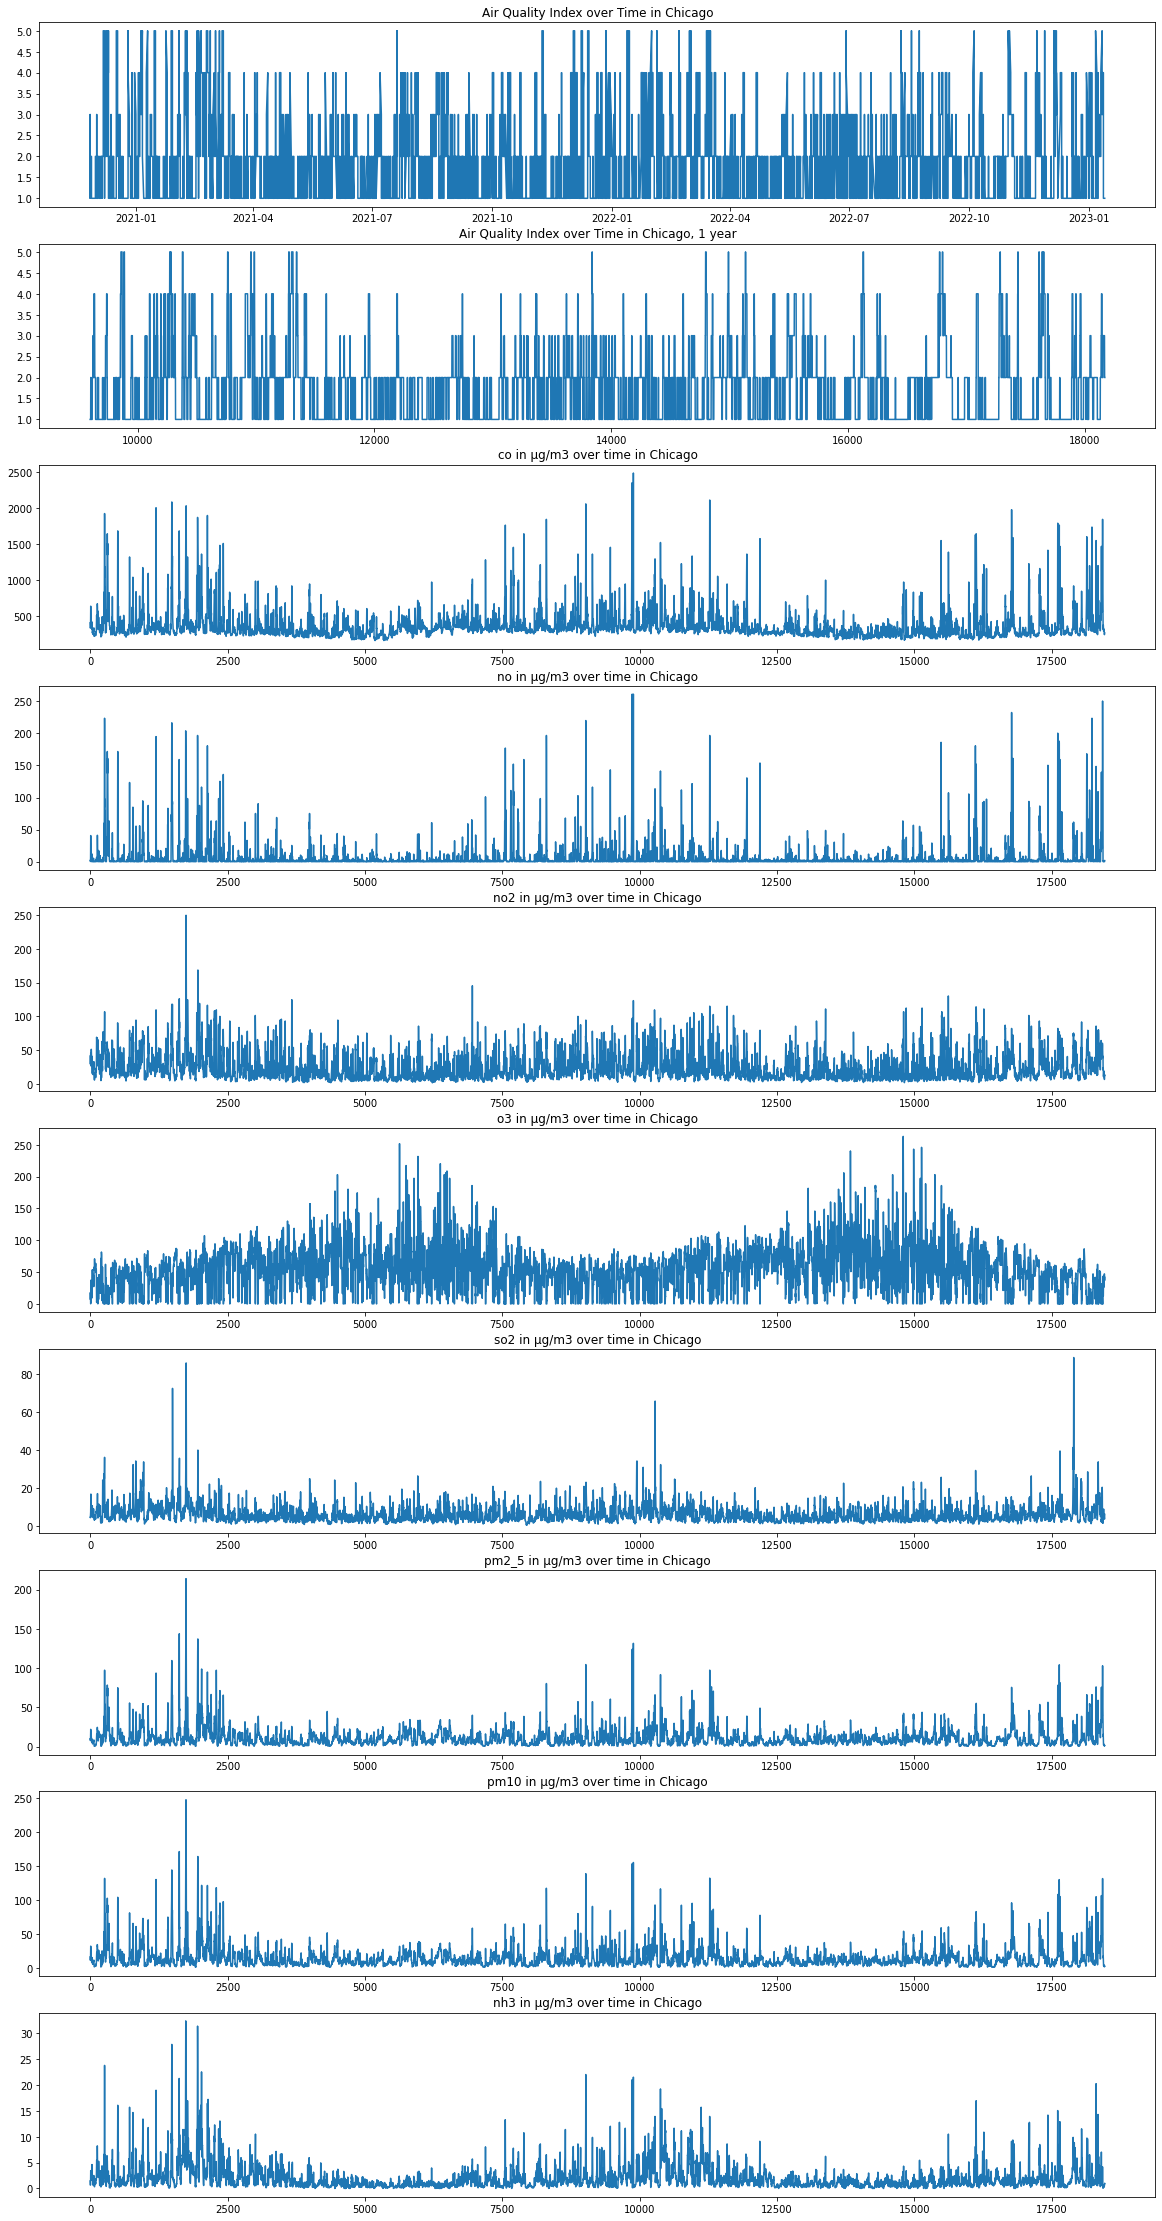

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(10, 1, figsize=(20,40))
ax1[0].plot(data.date, data['aqi'])
ax1[0].set(title='Air Quality Index over Time in Chicago')

year = data.loc[(data.date > '01-01-2022') & (data.date < '01-01-2023')]
ax1[1].plot(year.index, year['aqi'])
ax1[1].set(title='Air Quality Index over Time in Chicago, 1 year')

predictors = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
for i in range(2, 10):
    ax1[i].plot(data.index, data[predictors[i-2]])
    ax1[i].set(title=f'{predictors[i-2]} in μg/m3 over time in Chicago')

From the plots above, we can clearly see that a lot of the pollutants are correlated directly with increases in air quality index (higher numbers are worse). The increases seem to be cyclic, with air quality index increasing in the winter months. However, we can also see that ozone concentrations are also cyclic, but with increases in the summer months. This is due to pollutants reacting with heat and sunlight.

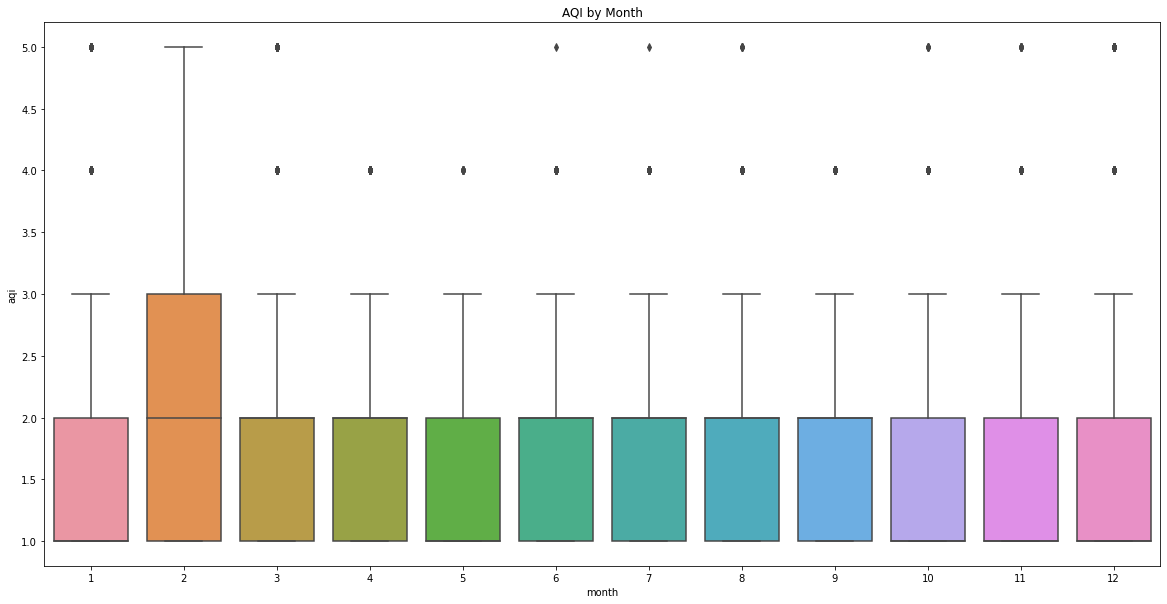

In [19]:
import seaborn as sns

data_with_month = data[['datetime', 'aqi']].copy()
data_with_month['month'] = pd.DatetimeIndex(data_with_month['datetime']).month
fig, ax1 = plt.subplots(figsize=(20,10))
sns.boxplot(data=data_with_month, x='month', y='aqi')
ax1.set(title='AQI by Month')
plt.show()

The boxplot above shows the distribution of AQIs by month in Chicago. Most of the months have a similar distribution of AQIs, which is nice for the people who live there. The air quality is generally pretty good! We *can* see, however, that the outliers in the dataset seem to be concentrated in the winter and summer months. This lines up with the peaks that we see in the time series plots above.

Finally, we can use a rolling average on the data to see if there is an underlying trend:

[Text(0.5, 1.0, 'Weekly Rolling Avg of Chicago AQI')]

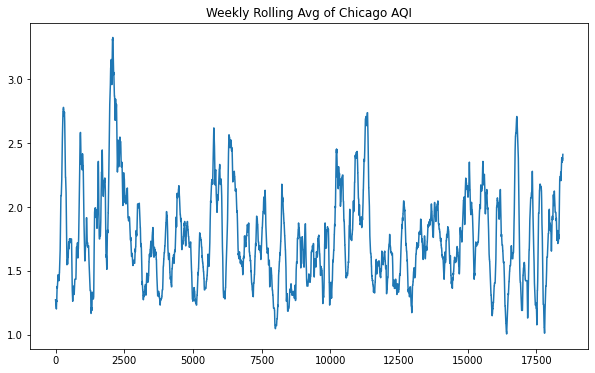

In [25]:
hours = 7*24
rolling_avg = data[['aqi']].rolling(window=hours, center=True, min_periods=int(hours/2)).mean()
rolling_avg

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(range(len(rolling_avg['aqi'])), rolling_avg['aqi'])
ax1.set(title='Weekly Rolling Avg of Chicago AQI')